In [7]:
import os
import sys
from pathlib import Path
from dataclasses import dataclass
from typing import Sequence, List, Tuple, Set, Dict, Optional, Any

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


In [8]:
cmap = mpl.colormaps.get('Set1')

mpl.rcParams['image.cmap'] = cmap
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=cmap.colors) 
mpl.rcParams['font.size'] = 22


In [9]:
PROJECT_ROOT_DIR = Path("..").absolute().resolve()

if str(PROJECT_ROOT_DIR) not in sys.path:
    sys.path.append(str(PROJECT_ROOT_DIR))
    
import experiments
from experiments import EXPERIMENTS_OUT_DIR

In [10]:
CSV_DIR = EXPERIMENTS_OUT_DIR / 'scale_final_2607'
assert CSV_DIR.is_dir()

In [11]:
@dataclass
class ExpResultFile:
    exp_name: str
    exp_timestamp: str
    exp_host: str
    exp_tag: str
    path: Path
    
exp_result_files = {}
for csv_path in CSV_DIR.glob("*.csv"):
    csv_path_parts = str(csv_path.stem).split("-")
    csv_out_tag = csv_path_parts[-1]
    csv_timestamp = csv_path_parts[-3]
    
    exp_result_files.setdefault(csv_out_tag, [])
    exp_outfile = ExpResultFile(*csv_path_parts, csv_path)
    exp_result_files[csv_out_tag].append(exp_outfile)

In [25]:
def plot_scale_exp(
    out_files: Sequence[ExpResultFile],
    sweep_column: str,
    metric_columns: Sequence[str],
    metric_legends: Sequence[str],
    metric_scales: Sequence[float],
    metric_names: Sequence[str],
    axis_names: Dict[str, str],
    fixed_columns: Sequence[str] = None,
    logx: bool = False,
    ax=None,
):
    
    # Load and add repeats
    file_dfs = []
    for i, out_file in enumerate(out_files):
        df_ = pd.read_csv(out_file.path)
        df_['repeat'] = i
        file_dfs.append(df_)
    
    df = pd.concat(file_dfs)
    
    # Group data for plotting
    df_groups = df.groupby(by=sweep_column)
    
    # Collect mean and std of each metric for each sweeped value 
    param_values, metric_means, metric_stds = [], {}, {}
    for group_name, df_group in df_groups:
        df_agg = df_group.aggregate({col: ['mean', 'std'] for col in metric_columns})
        
        param_values.append(group_name)
        for metric_col, metric_scale in zip(df_agg.columns, metric_scales):
            metric_means.setdefault(metric_col, [])
            metric_stds.setdefault(metric_col, [])
            metric_means[metric_col].append(df_agg.loc['mean', metric_col]*metric_scale)
            metric_stds[metric_col].append(df_agg.loc['std', metric_col]*metric_scale)
            
    param_values = np.array(param_values)
    
    # Collect fixed values
    fixed_values = {}
    for fixed_col in (fixed_columns or []):
        fixed_col_values = df[fixed_col].values
        if np.all(np.isnan(fixed_col_values)):
            continue
        # assert np.allclose(fixed_col_values, fixed_col_values[0])
        fixed_col = fixed_col.split('.')[-1]
        fixed_values[fixed_col] = fixed_col_values[0]
            
    # plot
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5), squeeze=True)
    
    lines = []
    for i, (metric_col, metric_name, metric_legend) in enumerate(zip(metric_columns, metric_names, metric_legends)):
        means = np.array(metric_means[metric_col])
        stds = np.array(metric_stds[metric_col])
        
        if i > 0:
            ax_ = ax.twinx()
            # ax_.set_xscale("log")
        else:
            ax_ = ax
            
        if i > 1:
            # right, left, top, bottom
            ax_.spines['right'].set_position(('outward', 50*i))
        
        l, *_ = ax_.plot(param_values, means, color=f'C{i}', label=metric_legend)
        ax_.fill_between(param_values, means+2*stds, means-2*stds, color=f"C{i}")
        # ax_.set_ylabel(metric_name, fontsize=20)
        [t.set_color(l.get_color()) for t in ax_.yaxis.get_ticklines()]
        [t.set_color(l.get_color()) for t in ax_.yaxis.get_ticklabels()]
        ax_.yaxis.label.set_color(l.get_color())
        # ax_.yaxis.label.set_color(l.get_color())
        # ax_.set_yscale('log')
        lines.append(l)

    
    ax_.legend(handles=lines, loc='upper left', prop={'size': 22})
    
    ax.set_xlabel(axis_names[sweep_column], fontsize=24)
    ax.grid()
    # ax.set_title(f"Sweep {sweep_column}: {str.join(', ', [f'{fc}={fv}' for fc, fv in fixed_values.items()])}")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    if logx:
        ax.set_xscale('log')
        
    return fig, ax
        

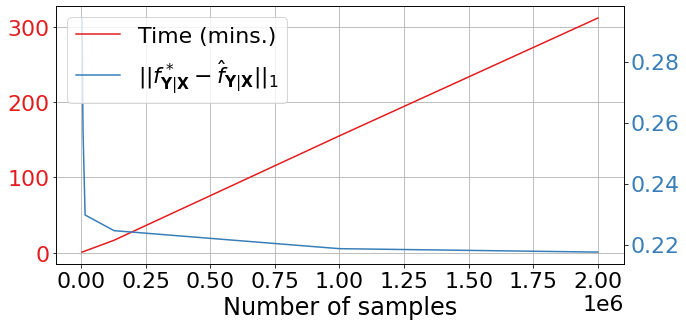

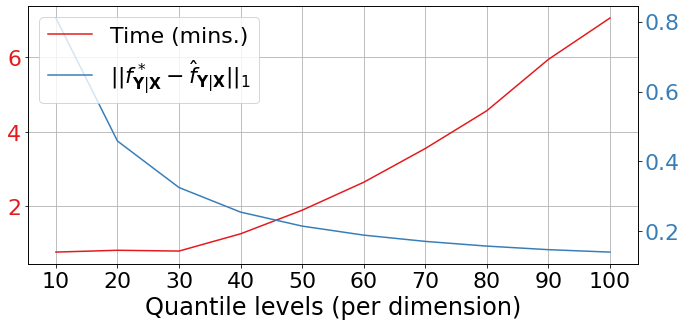

In [29]:
all_sweep_params = {'N','T', 'd', 'k','solver.batchsize_y','solver.batchsize_u'}
plot_param_tags = [('N',), ('T', ),]

for sweep_param, *out_tag in plot_param_tags:
    out_tag = out_tag[0] if out_tag else sweep_param
    
    fig, ax = plot_scale_exp(
        exp_result_files[out_tag],
        sweep_column=sweep_param,
        metric_columns=['total_time', 'kde_l1'],
        metric_legends=["Time (mins.)",  r"$||f^*_{\mathbf{Y}|\mathbf{X}} - \hat{f}_{\mathbf{Y}|\mathbf{X}}||_1$"],
        metric_scales=[1/60, 100**2],
        metric_names=["Time (mins.)", r"$||f^*_{\mathbf{Y}|\mathbf{X}} - \hat{f}_{\mathbf{Y}|\mathbf{X}}||_1$"],
        axis_names={'N': "Number of samples",
                    "T": "Quantile levels (per dimension)",
                    "d": "Target dimensions",
                    "k": "Covariate dimensions"},
        # fixed_columns=list(all_sweep_params-{sweep_param}),
        logx=out_tag in ['k'],
    );

    fig_filename = CSV_DIR / f"fig_{out_tag}.png"
    plt.tight_layout()
    fig.savefig(fig_filename, bbox_inches='tight', dpi=300)
